<a href="https://colab.research.google.com/github/arthurziegler/ner-using-bert/blob/main/BERT_Experiment/bert_ner_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First test of the BERT model for NER
Using [an implementation by Tobias Sterbak](https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/) as a base for the tests of the application of bert in this problem.

In [1]:
#!pip install transformers

In [338]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import os.path

torch.__version__

pd.options.display.max_colwidth = 300
pd.options.display.max_rows = 100
pd.options.display.max

# Get kaggle dataset

In [26]:
cwd = os.getcwd()
if not(os.path.exists(cwd + "/kaggle_ner_dataset/ner_dataset.csv")):
    !wget https://media.githubusercontent.com/media/arthurziegler/ner-using-bert/main/BERT_Experiment/kaggle_ner_dataset/ner_dataset.csv

In [323]:
kaggle_data = pd.read_csv("kaggle_ner_dataset/ner_dataset.csv", encoding="latin1").fillna(method="ffill")
kaggle_data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


# Get ACERPI dataset

In [339]:
#import tokenizer from nltk that is able to separate text into sentences.
from nltk import tokenize, download
download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arthu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [400]:
annotated_data = pd.read_json("acerpi_dataset/test/annotated/ner_ufrgs_test.jsonl", lines=True)

## Formatting the dataset
The first thing we'll do is to put the dataset in a format where we have the document text and a list of labeled tokens. When importing from the spacy anotattion, the labels are not formatted by token, so we will need to go through the *spans* columns and the *tokens* columns to change the labelling from by document to be by token.

In [375]:
formatted_dataset = annotated_data.copy(deep=True)

In [377]:
#entity_tokens = []
for index, document in formatted_dataset.iterrows():
    #print(index, document['spans'])
    #index = int(index)
    entity_tokens = []
    for entity in document['spans']:
        # Add the index of the tokens that belong to this named entity in the list
        entity_tokens += range(entity['token_start'], entity['token_end'] + 1, 1)
        #print(entity)

    for token in document['tokens']:
        if token['id'] in entity_tokens:
            token['tag'] = 'PER'
        else:
            token['tag'] = 'O'
        token['document'] = index


In [378]:
formatted_dataset.head(2)

,text,_input_hash,_task_hash,tokens,spans,_session_id,_view_id,answer
0,"Documento gerado sob autenticação Nº CSJ.247.095.BI5, disponível no endereço http://www.ufrgs.br/autenticacao Documento certificado eletronicamente, conforme Portaria nº 3362/2016, que institui o Sistema de Documentos Eletrônicos da UFRGS. 1/1 PORTARIA Nº 6629 de 24/07/2019 A VICE-REITORA, NO EX...",-750732489,1074366513,"[{'text': 'Documento', 'start': 0, 'end': 9, 'id': 0, 'tag': 'O', 'document': 0}, {'text': 'gerado', 'start': 10, 'end': 16, 'id': 1, 'tag': 'O', 'document': 0}, {'text': 'sob', 'start': 17, 'end': 20, 'id': 2, 'tag': 'O', 'document': 0}, {'text': 'autenticação', 'start': 21, 'end': 33, 'id': 3,...","[{'start': 592, 'end': 622, 'token_start': 100, 'token_end': 103, 'label': 'PER'}, {'start': 677, 'end': 696, 'token_start': 119, 'token_end': 121, 'label': 'PER'}]",NaN,ner_manual,accept
1,"Documento gerado sob autenticação Nº BOA.507.615.IRF, disponível no endereço http://www.ufrgs.br/autenticacao Documento certificado eletronicamente, conforme Portaria nº 3362/2016, que institui o Sistema de Documentos Eletrônicos da UFRGS. 1/1 PORTARIA Nº 1956 de 05/03/2020 O PRÓ-REITOR DE GESTÃ...",-1305314382,-1539925525,"[{'text': 'Documento', 'start': 0, 'end': 9, 'id': 0, 'tag': 'O', 'document': 1}, {'text': 'gerado', 'start': 10, 'end': 16, 'id': 1, 'tag': 'O', 'document': 1}, {'text': 'sob', 'start': 17, 'end': 20, 'id': 2, 'tag': 'O', 'document': 1}, {'text': 'autenticação', 'start': 21, 'end': 33, 'id': 3,...","[{'token_start': 152, 'token_end': 155, 'start': 796, 'end': 827, 'text': 'FELIPE ANTÔNIO GUIDI SAUERESSIG', 'label': 'PER', 'source': 'models/ufrgs_second', 'input_hash': -1305314382}, {'token_start': 167, 'token_end': 169, 'start': 866, 'end': 885, 'text': 'JOSE EDUARDO HANDEL', 'label': 'PER'...",NaN,ner_manual,accept


In [404]:
formatted_dataset['tokens'][0][0:5]

[{'text': 'Documento',
  'start': 0,
  'end': 9,
  'id': 0,
  'tag': 'O',
  'document': 0},
 {'text': 'gerado',
  'start': 10,
  'end': 16,
  'id': 1,
  'tag': 'O',
  'document': 0},
 {'text': 'sob', 'start': 17, 'end': 20, 'id': 2, 'tag': 'O', 'document': 0},
 {'text': 'autenticação',
  'start': 21,
  'end': 33,
  'id': 3,
  'tag': 'O',
  'document': 0},
 {'text': 'Nº', 'start': 34, 'end': 36, 'id': 4, 'tag': 'O', 'document': 0}]

In [380]:
tagged_tokens = formatted_dataset['tokens'].to_numpy()

token_dict_list = []
for index, dict_list in enumerate(tagged_tokens):
    token_dict_list += dict_list


In [381]:
token_dict_list[0:4]

[{'text': 'Documento',
  'start': 0,
  'end': 9,
  'id': 0,
  'tag': 'O',
  'document': 0},
 {'text': 'gerado',
  'start': 10,
  'end': 16,
  'id': 1,
  'tag': 'O',
  'document': 0},
 {'text': 'sob', 'start': 17, 'end': 20, 'id': 2, 'tag': 'O', 'document': 0},
 {'text': 'autenticação',
  'start': 21,
  'end': 33,
  'id': 3,
  'tag': 'O',
  'document': 0}]

In [402]:
pd.options.display.max_rows = None
token_df = pd.DataFrame(token_dict_list)

#token_df[token_df['tag'] == 'PER'].head(200)
token_df[token_df['document'] == 1]['text'][0:10]

131          Documento
132             gerado
133                sob
134       autenticação
135                 Nº
136    BOA.507.615.IRF
137                  ,
138         disponível
139                 no
140           endereço
Name: text, dtype: object

## Clean the text
The document text contains several things like repeated spaces, new line character and wrong punctuation that could break our sentence split afterwards

In [401]:
print((annotated_data['text'][1]))
# #Remove \n character and repeated whitespaces
annotated_data['text'] = annotated_data['text'].replace(r'(nº\.) ?','nº ', regex=True)
annotated_data['text'] = annotated_data['text'].replace(r'\n',' ', regex=True)
annotated_data['text'] = annotated_data['text'].replace(r'[ ]+', ' ', regex = True)
#print(annotated_data['text'][1])

Documento gerado sob autenticação Nº BOA.507.615.IRF, disponível no endereço
http://www.ufrgs.br/autenticacao
Documento certificado eletronicamente, conforme Portaria nº
3362/2016, que institui o Sistema de Documentos Eletrônicos da UFRGS.
1/1
PORTARIA Nº             1956                  de  05/03/2020
O PRÓ-REITOR DE GESTÃO DE PESSOAS DA UNIVERSIDADE FEDERAL DO RIO GRANDE DO SUL, no
uso de suas atribuições que lhe foram conferidas pela Portaria nº.7684, de 03 de outubro de 2016, do
Magnífico Reitor, e conforme o Laudo Médico n°60170,
RESOLVE
Designar, temporariamente, nos termos da Lei nº. 8.112, de 11 de dezembro de 1990, com redação
dada pela Lei  nº.9.527,  de 10 de dezembro de 1997, o ocupante do cargo de TÉCNICO EM ASSUNTOS
EDUCACIONAIS, do Quadro de Pessoal desta Universidade, FELIPE ANTÔNIO GUIDI SAUERESSIG (Siape:
1963089 ),  para substituir   JOSE EDUARDO HANDEL (Siape: 0357511 ), Secretário da COMGRAD de Nutrição,
Código  FG-7,  em seu afastamento  por  motivo  de  Laudo Mé

## Clean the tokens
The tokens also contain several instances of this bad formatting which we have to remove

In [ ]:
print((annotated_data['text'][1]))
# #Remove \n character and repeated whitespaces
annotated_data['text'] = annotated_data['text'].replace(r'(nº\.) ?','nº ', regex=True)
annotated_data['text'] = annotated_data['text'].replace(r'\n',' ', regex=True)
annotated_data['text'] = annotated_data['text'].replace(r'[ ]+', ' ', regex = True)
#print(annotated_data['text'][1])

In [365]:
# #Split documents into phrases
#sentence_df = annotated_data['text'].apply(lambda row: tokenize.sent_tokenize(row, language='portuguese'))
sentence_df = annotated_data['text'].str.split(pat='\. ')
# #Turn series of list of phrases into series of phrases. Index will indicate which document it belongs to for now.
sentence_df = sentence_df.explode()

In [366]:
pd.DataFrame(sentence_df).head(30)

,text
0,"Documento gerado sob autenticação Nº CSJ.247.095.BI5, disponível no endereço http://www.ufrgs.br/autenticacao Documento certificado eletronicamente, conforme Portaria nº 3362/2016, que institui o Sistema de Documentos Eletrônicos da UFRGS"
0,"1/1 PORTARIA Nº 6629 de 24/07/2019 A VICE-REITORA, NO EXERCÍCIO DA REITORIA DA UNIVERSIDADE FEDERAL DO RIO GRANDE DO SUL, no uso de suas atribuições legais e estatutárias RESOLVE Tornar insubsistente a Portaria nº 5310/2019, de 24/06/2019, publicada no Diário Oficial da União de 27/06/2019, que ..."
0,"JANE FRAGA TUTIKIAN Vice-Reitora, no exercício da Reitoria"
0,
1,"Documento gerado sob autenticação Nº BOA.507.615.IRF, disponível no endereço http://www.ufrgs.br/autenticacao Documento certificado eletronicamente, conforme Portaria nº 3362/2016, que institui o Sistema de Documentos Eletrônicos da UFRGS"
1,"1/1 PORTARIA Nº 1956 de 05/03/2020 O PRÓ-REITOR DE GESTÃO DE PESSOAS DA UNIVERSIDADE FEDERAL DO RIO GRANDE DO SUL, no uso de suas atribuições que lhe foram conferidas pela Portaria nº.7684, de 03 de outubro de 2016, do Magnífico Reitor, e conforme o Laudo Médico n°60170, RESOLVE Designar, tempor..."
1,"8.112, de 11 de dezembro de 1990, com redação dada pela Lei nº.9.527, de 10 de dezembro de 1997, o ocupante do cargo de TÉCNICO EM ASSUNTOS EDUCACIONAIS, do Quadro de Pessoal desta Universidade, FELIPE ANTÔNIO GUIDI SAUERESSIG (Siape: 1963089 ), para substituir JOSE EDUARDO HANDEL (Siape: 035751..."
1,MAURÍCIO VIÉGAS DA SILVA Pró-Reitor de Gestão de Pessoas
2,"Documento gerado sob autenticação Nº LKB.506.405.IRF, disponível no endereço http://www.ufrgs.br/autenticacao Documento certificado eletronicamente, conforme Portaria nº 3362/2016, que institui o Sistema de Documentos Eletrônicos da UFRGS"
2,"1/1 PORTARIA Nº 1955 de 05/03/2020 O PRÓ-REITOR DE GESTÃO DE PESSOAS DA UNIVERSIDADE FEDERAL DO RIO GRANDE DO SUL, no uso de suas atribuições que lhe foram conferidas pela Portaria nº.7684, de 03 de outubro de 2016, do Magnífico Reitor, e conforme o Laudo Médico n°60131, RESOLVE Designar, tempor..."


# Data pre-processing and token generation

In [30]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [317]:
getter = SentenceGetter(kaggle_data)

In [326]:
getter.sentences

[[('Thousands', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('demonstrators', 'NNS', 'O'),
  ('have', 'VBP', 'O'),
  ('marched', 'VBN', 'O'),
  ('through', 'IN', 'O'),
  ('London', 'NNP', 'B-geo'),
  ('to', 'TO', 'O'),
  ('protest', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('war', 'NN', 'O'),
  ('in', 'IN', 'O'),
  ('Iraq', 'NNP', 'B-geo'),
  ('and', 'CC', 'O'),
  ('demand', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('withdrawal', 'NN', 'O'),
  ('of', 'IN', 'O'),
  ('British', 'JJ', 'B-gpe'),
  ('troops', 'NNS', 'O'),
  ('from', 'IN', 'O'),
  ('that', 'DT', 'O'),
  ('country', 'NN', 'O'),
  ('.', '.', 'O')],
 [('Iranian', 'JJ', 'B-gpe'),
  ('officials', 'NNS', 'O'),
  ('say', 'VBP', 'O'),
  ('they', 'PRP', 'O'),
  ('expect', 'VBP', 'O'),
  ('to', 'TO', 'O'),
  ('get', 'VB', 'O'),
  ('access', 'NN', 'O'),
  ('to', 'TO', 'O'),
  ('sealed', 'JJ', 'O'),
  ('sensitive', 'JJ', 'O'),
  ('parts', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('the', 'DT', 'O'),
  ('plant', 'NN', 'O'),
  ('Wednesday', 'NNP', 'B-tim'),
  ('

In [320]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [319]:
sentences[2]

['Helicopter',
 'gunships',
 'Saturday',
 'pounded',
 'militant',
 'hideouts',
 'in',
 'the',
 'Orakzai',
 'tribal',
 'region',
 ',',
 'where',
 'many',
 'Taliban',
 'militants',
 'are',
 'believed',
 'to',
 'have',
 'fled',
 'to',
 'avoid',
 'an',
 'earlier',
 'military',
 'offensive',
 'in',
 'nearby',
 'South',
 'Waziristan',
 '.']

In [33]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [34]:
tag_values = list(set(kaggle_data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [321]:
MAX_LEN = 75
bs = 32

In [322]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
device

device(type='cuda')

In [38]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1070 Ti'

In [39]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

Downloading: 100%|██████████| 208k/208k [00:00<00:00, 266kB/s]
Downloading: 100%|██████████| 29.0/29.0 [00:00<00:00, 6.50kB/s]
Downloading: 100%|██████████| 426k/426k [00:01<00:00, 244kB/s]
Downloading: 100%|██████████| 570/570 [00:00<00:00, 575kB/s]


In [40]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [41]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [42]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [43]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [44]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [45]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [46]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [56]:
tr_tags[0]

array([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,
        4,  4,  5,  3, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17])

In [59]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [391]:
tr_inputs[0]

tensor([ 1335,  1655,  1421, 22452,  1138,  1151,  1841,  1107,   170, 19850,
         2035,  1113,   170,  2699,  3227,  1107,  1890,   118,  4013, 13705,
          119,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0], dtype=torch.int32)

In [22]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [23]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'4.11.2'

In [24]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [25]:
model.cuda();

In [26]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [27]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [28]:
!pip install seqeval==0.0.12
from seqeval.metrics import f1_score, accuracy_score

In [29]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.19241763099895484
Validation loss: 0.13638718508183956
Validation Accuracy: 0.9575689206547874


Epoch:  33%|███▎      | 1/3 [20:15<40:31, 1215.58s/it]

Validation F1-Score: 0.8129507166581884

Average train loss: 0.10966250704141614
Validation loss: 0.12430109277367592
Validation Accuracy: 0.9615131253911268


Epoch:  67%|██████▋   | 2/3 [40:14<20:05, 1205.96s/it]

Validation F1-Score: 0.8285722868042413

Average train loss: 0.08197432681586762
Validation loss: 0.12975456625223158
Validation Accuracy: 0.9620977569908764


Epoch: 100%|██████████| 3/3 [1:00:24<00:00, 1208.07s/it]

Validation F1-Score: 0.8306360107494775



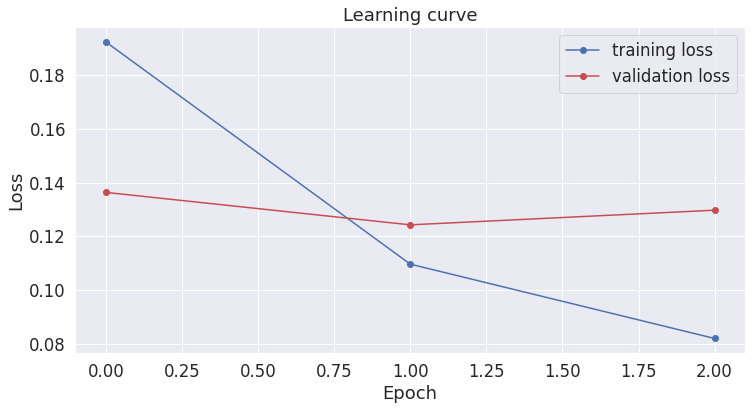

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()